# PASD - Sentiment Analysis

Kelompok 19

Anggota:


1.   X
2.   X
3.   X



## Importing Library

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

!pip install google-play-scraper
from google_play_scraper import Sort, reviews

!pip install catboost
from catboost import CatBoostClassifier

!pip install optuna
import optuna

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Scraping The Data

In [5]:
from google_play_scraper import Sort
from google_play_scraper.constants.element import ElementSpecs
from google_play_scraper.constants.regex import Regex
from google_play_scraper.constants.request import Formats
from google_play_scraper.utils.request import post

import json
from typing import List, Optional, Tuple

from datetime import datetime
from tqdm import tqdm
import time

app_id = 'gov.dukcapil.mobile_id'

MAX_COUNT_EACH_FETCH = 199


class _ContinuationToken:
    __slots__ = (
        "token",
        "lang",
        "country",
        "sort",
        "count",
        "filter_score_with",
        "filter_device_with",
    )

    def __init__(
        self, token, lang, country, sort, count, filter_score_with, filter_device_with
    ):
        self.token = token
        self.lang = lang
        self.country = country
        self.sort = sort
        self.count = count
        self.filter_score_with = filter_score_with
        self.filter_device_with = filter_device_with


def _fetch_review_items(
    url: str,
    app_id: str,
    sort: int,
    count: int,
    filter_score_with: Optional[int],
    filter_device_with: Optional[int],
    pagination_token: Optional[str],
):
    dom = post(
        url,
        Formats.Reviews.build_body(
            app_id,
            sort,
            count,
            "null" if filter_score_with is None else filter_score_with,
            "null" if filter_device_with is None else filter_device_with,
            pagination_token,
        ),
        {"content-type": "application/x-www-form-urlencoded"},
    )
    match = json.loads(Regex.REVIEWS.findall(dom)[0])

    return json.loads(match[0][2])[0], json.loads(match[0][2])[-2][-1]


def reviews(
    app_id: str,
    lang: str = "en",
    country: str = "us",
    sort: Sort = Sort.MOST_RELEVANT,
    count: int = 100,
    filter_score_with: int = None,
    filter_device_with: int = None,
    continuation_token: _ContinuationToken = None,
) -> Tuple[List[dict], _ContinuationToken]:
    sort = sort.value

    if continuation_token is not None:
        token = continuation_token.token

        if token is None:
            return (
                [],
                continuation_token,
            )

        lang = continuation_token.lang
        country = continuation_token.country
        sort = continuation_token.sort
        count = continuation_token.count
        filter_score_with = continuation_token.filter_score_with
        filter_device_with = continuation_token.filter_device_with
    else:
        token = None

    url = Formats.Reviews.build(lang=lang, country=country)

    _fetch_count = count

    result = []

    while True:
        if _fetch_count == 0:
            break

        if _fetch_count > MAX_COUNT_EACH_FETCH:
            _fetch_count = MAX_COUNT_EACH_FETCH

        try:
            review_items, token = _fetch_review_items(
                url,
                app_id,
                sort,
                _fetch_count,
                filter_score_with,
                filter_device_with,
                token,
            )
        except (TypeError, IndexError):
            #funnan MOD start
            token = continuation_token.token
            continue
            #MOD end

        for review in review_items:
            result.append(
                {
                    k: spec.extract_content(review)
                    for k, spec in ElementSpecs.Review.items()
                }
            )

        _fetch_count = count - len(result)

        if isinstance(token, list):
            token = None
            break

    return (
        result,
        _ContinuationToken(
            token, lang, country, sort, count, filter_score_with, filter_device_with
        ),
    )


def reviews_all(app_id: str, sleep_milliseconds: int = 0, **kwargs) -> list:
    kwargs.pop("count", None)
    kwargs.pop("continuation_token", None)

    continuation_token = None

    result = []

    while True:
        _result, continuation_token = reviews(
            app_id,
            count=MAX_COUNT_EACH_FETCH,
            continuation_token=continuation_token,
            **kwargs
        )

        result += _result

        if continuation_token.token is None:
            break

        if sleep_milliseconds:
            sleep(sleep_milliseconds / 1000)

    return result

result = []
continuation_token = None
reviews_count = 20000

with tqdm(total=reviews_count, position=0, leave=True) as pbar:
    while len(result) < reviews_count:
        new_result, continuation_token = reviews(
            app_id,
            continuation_token=continuation_token,
            lang='id',
            country='id',
            sort=Sort.MOST_RELEVANT,
            filter_score_with=None,
            count=199
        )
        if not new_result:
            break
        result.extend(new_result)
        pbar.update(len(new_result))

20099it [00:57, 350.35it/s]


## Creating The Dataframe

In [6]:
df = pd.DataFrame(result)
df = df[["content","score"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20099 entries, 0 to 20098
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  20099 non-null  object
 1   score    20099 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 314.2+ KB


In [7]:
df.head()

,content,score
0,Apasih gunanya E-KTP tapi gak bisa cetak KTP-n...,1
1,"Aplikasi nya ""terjadi kesalahan koneksi"" ,suda...",1
2,"Sangat,,,, sangat,,, sangat jelek & buruk,,, u...",1
3,"Aplikasi apa ini, tidak membantu sama sekali,,...",1
4,Konsep aplikasi ini sudah bagus. Masih ada ban...,1


## Classifying Score Tone

In [8]:
df['tone'] = df['score'].apply(lambda x: 1 if x > 3 else -1)

## Saving Dataframe

In [9]:
df.to_csv('pasd_ikd_dataset_final.csv', index=False)

## EDA

### Checking Class Distribution

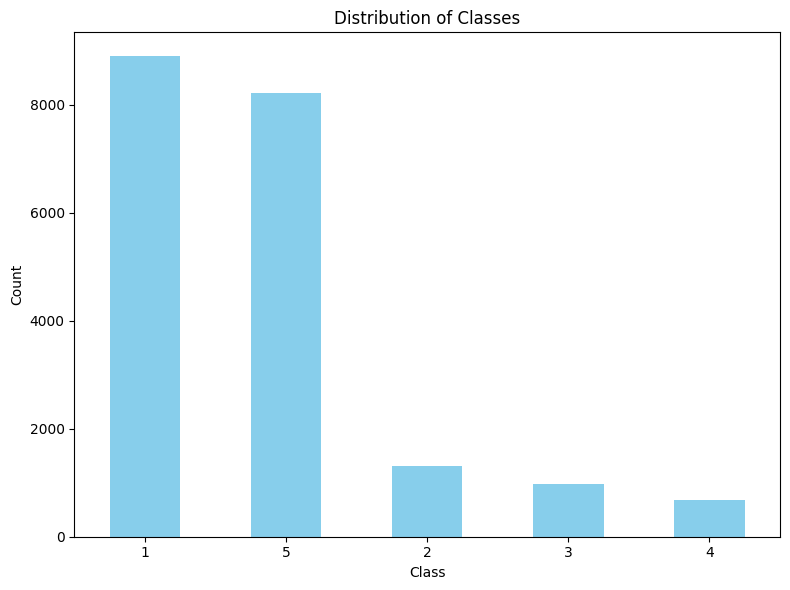

In [10]:
# Mengambil nilai perhitungan distribusi kelas
class_counts = df['score'].value_counts()

# Membuat diagram batang
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Untuk memutar label sumbu x agar lebih mudah dibaca
plt.tight_layout()
plt.show()

### Checking Tone Distribution

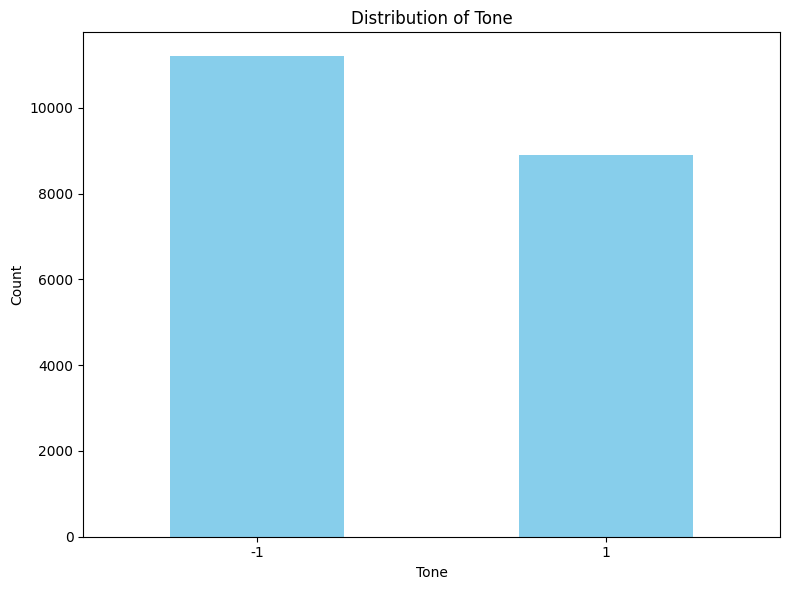

In [11]:
# Mengambil nilai perhitungan distribusi kelas
class_counts = df['tone'].value_counts()

# Membuat diagram batang
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Tone')
plt.xlabel('Tone')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Untuk memutar label sumbu x agar lebih mudah dibaca
plt.tight_layout()
plt.show()

### Creating Positive Wordcloud

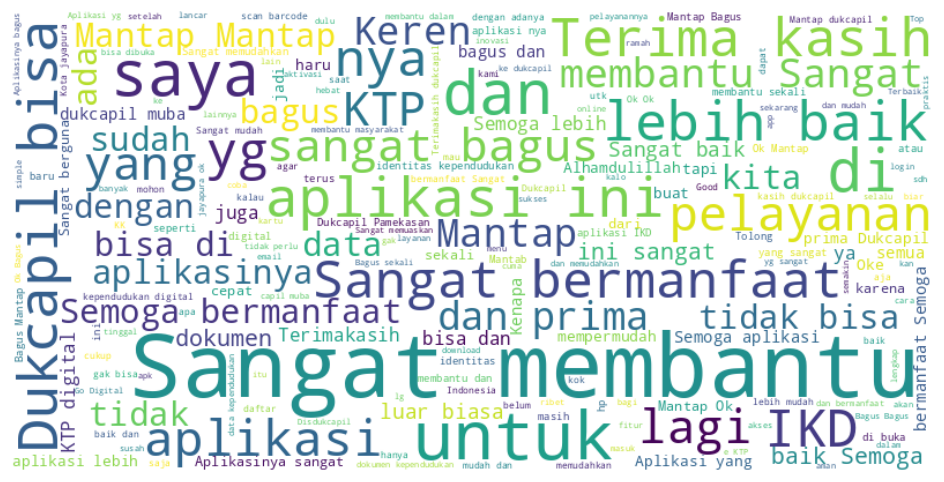

In [12]:
# Menggabungkan teks dari kolom "content" menjadi satu string
text = " ".join(df[df['tone'] == 1]['content'])

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Menampilkan WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Creating Negative Wordcloud

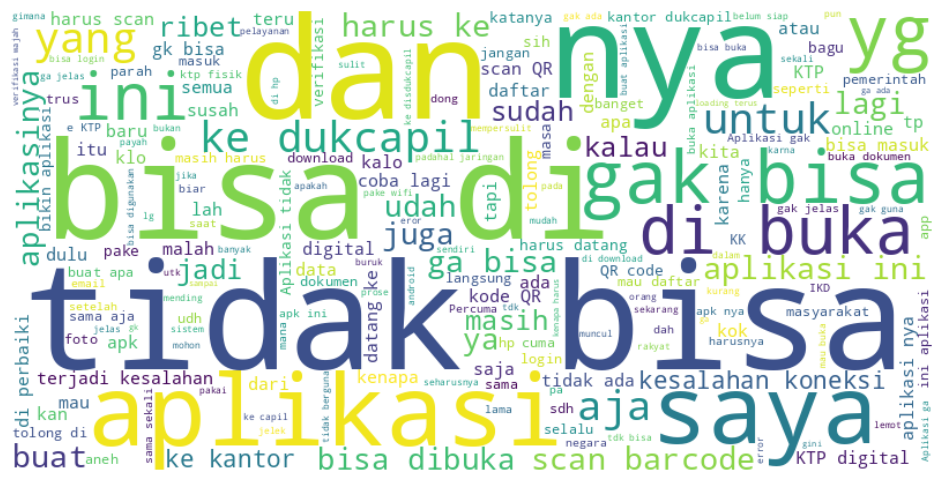

In [13]:
# Menggabungkan teks dari kolom "content" menjadi satu string
text = " ".join(df[df['tone'] == -1]['content'])

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Menampilkan WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 25 Most Common Positive Word

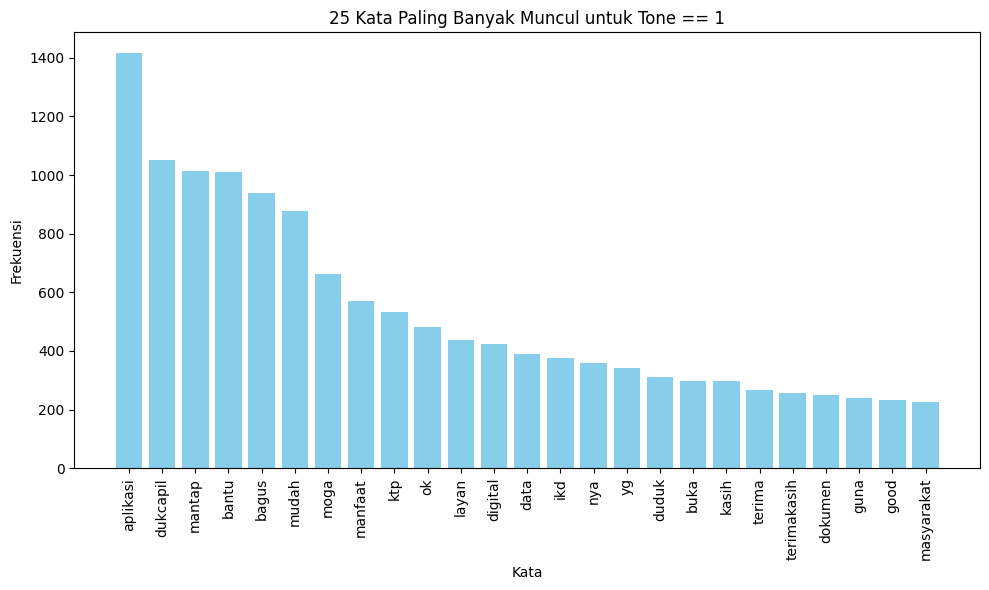

In [56]:
# Filter DataFrame untuk tone == 1
df_positive_tone = df[df['tone'] == 1]

# Gabungkan semua teks dalam satu string
all_text = ' '.join(df_positive_tone['content'])

# Split teks menjadi kata-kata
words = all_text.split()

# Hitung frekuensi masing-masing kata
word_counts = Counter(words)

# Ambil 25 kata teratas yang paling sering muncul
top_25_words = dict(word_counts.most_common(25))

# Buat visualisasi diagram batang
plt.figure(figsize=(10, 6))
plt.bar(top_25_words.keys(), top_25_words.values(), color='skyblue')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.title('25 Kata Paling Banyak Muncul untuk Tone == 1')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### 25 Most Common Negative Word

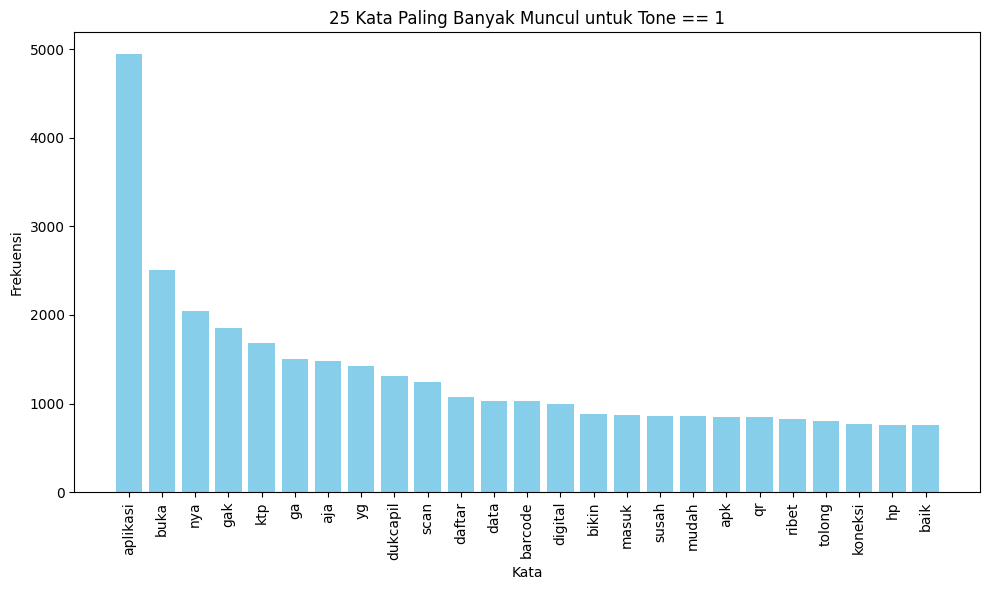

In [57]:
# Filter DataFrame untuk tone == 1
df_negative_tone = df[df['tone'] == -1]

# Gabungkan semua teks dalam satu string
all_text = ' '.join(df_negative_tone['content'])

# Split teks menjadi kata-kata
words = all_text.split()

# Hitung frekuensi masing-masing kata
word_counts = Counter(words)

# Ambil 25 kata teratas yang paling sering muncul
top_25_words = dict(word_counts.most_common(25))

# Buat visualisasi diagram batang
plt.figure(figsize=(10, 6))
plt.bar(top_25_words.keys(), top_25_words.values(), color='skyblue')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.title('25 Kata Paling Banyak Muncul untuk Tone == 1')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 15 Most Common Positive Word By Bi-Gram

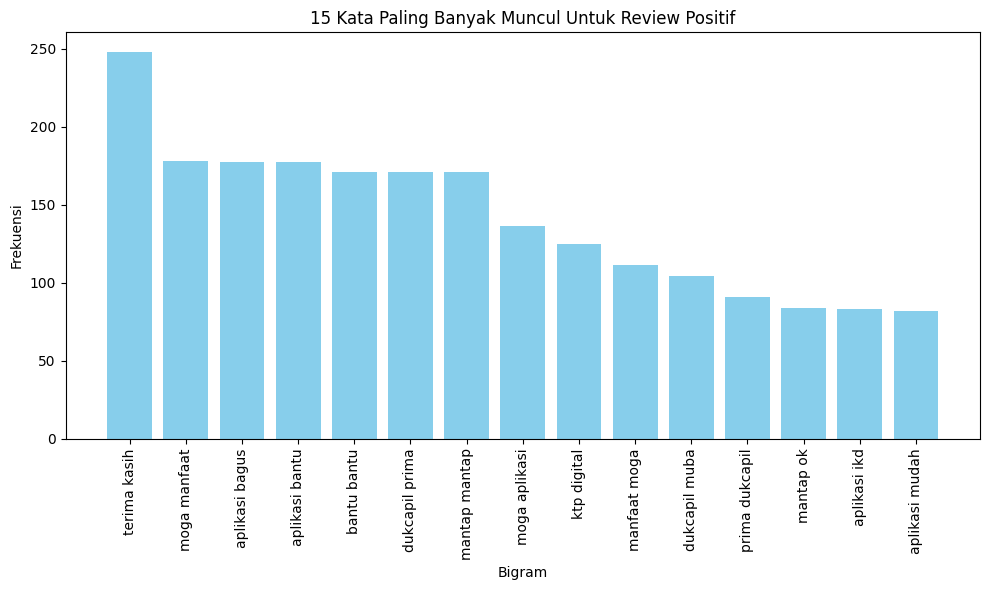

In [65]:
# Gabungkan semua teks dalam satu string
all_text = ' '.join(df_positive_tone['content'])

# Inisialisasi CountVectorizer dengan ngram_range=(2, 2) untuk bigram
vectorizer = CountVectorizer(ngram_range=(2, 2))

# Transformasi teks menjadi vektor fitur bigram
X = vectorizer.fit_transform([all_text])

# Ambil fitur (bigram) dan frekuensi masing-masing
features = vectorizer.get_feature_names_out()
frequencies = X.toarray()[0]

# Buat dictionary dengan pasangan bigram dan frekuensinya
bigram_freq_dict = dict(zip(features, frequencies))

# Ambil 15 bigram teratas
top_15_bigrams = dict(sorted(bigram_freq_dict.items(), key=lambda item: item[1], reverse=True)[:15])

# Buat visualisasi diagram batang
plt.figure(figsize=(10, 6))
plt.bar(top_15_bigrams.keys(), top_15_bigrams.values(), color='skyblue')
plt.xlabel('Bigram')
plt.ylabel('Frekuensi')
plt.title('15 Kata Paling Banyak Muncul Untuk Review Positif')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 15 Most Common Negative Word By Bi-Gram

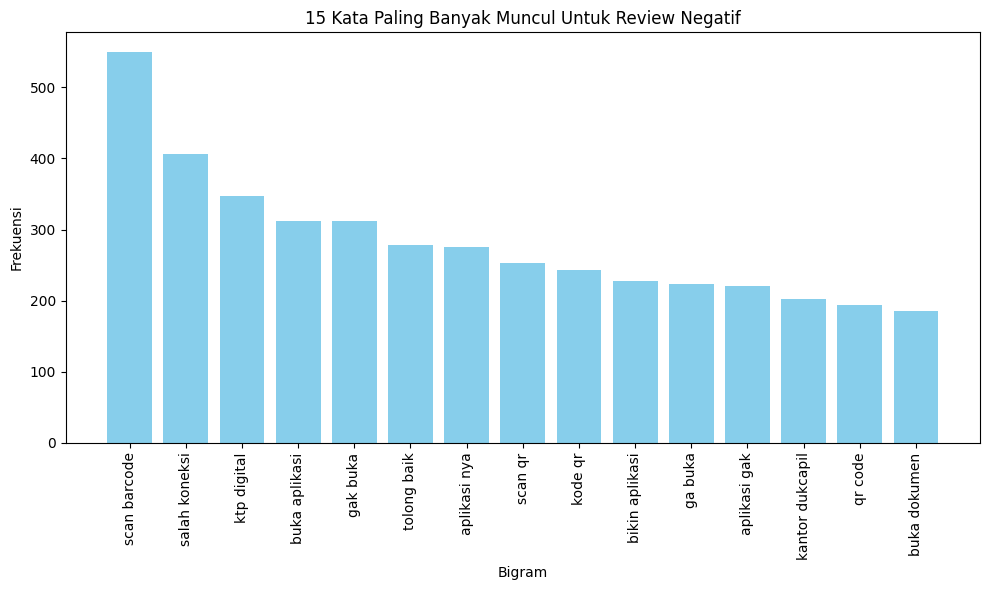

In [64]:
# Gabungkan semua teks dalam satu string
all_text = ' '.join(df_negative_tone['content'])

# Inisialisasi CountVectorizer dengan ngram_range=(2, 2) untuk bigram
vectorizer = CountVectorizer(ngram_range=(2, 2))

# Transformasi teks menjadi vektor fitur bigram
X = vectorizer.fit_transform([all_text])

# Ambil fitur (bigram) dan frekuensi masing-masing
features = vectorizer.get_feature_names_out()
frequencies = X.toarray()[0]

# Buat dictionary dengan pasangan bigram dan frekuensinya
bigram_freq_dict = dict(zip(features, frequencies))

# Ambil 15 bigram teratas
top_15_bigrams = dict(sorted(bigram_freq_dict.items(), key=lambda item: item[1], reverse=True)[:15])

# Buat visualisasi diagram batang
plt.figure(figsize=(10, 6))
plt.bar(top_15_bigrams.keys(), top_15_bigrams.values(), color='skyblue')
plt.xlabel('Bigram')
plt.ylabel('Frekuensi')
plt.title('15 Kata Paling Banyak Muncul Untuk Review Negatif')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Cleaning The Data

### Defining Stopwords

In [14]:
all_stopwords = stopwords.words('indonesian')

# Kata-kata negasi yang ingin dihapus dari kumpulan stopwords
kata_negasi = ['tidak', 'bukan', 'tak', 'tiada', 'belum', 'jangan', 'enggak', 'takkan', 'tidaklah', 'takluk']

# Hapus kata-kata negasi dari kumpulan stopwords
stopwords = [word for word in all_stopwords if word not in kata_negasi]

### Defining Stemmer

In [15]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

### Creating Preprocessing Function

In [16]:
def preprocess_text(text):
    # Hapus karakter non-alphanumeric
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Konversi teks ke huruf kecil
    text = text.lower()
    # Split teks menjadi kata-kata
    words = text.split()
    # Lematisasi dan hapus stop words
    processed_words = []
    for word in tqdm(words, desc="Preprocessing"):
        if word not in set(all_stopwords):
            processed_words.append(stemmer.stem(word))
    # Gabungkan kata-kata kembali menjadi satu string
    processed_text = ' '.join(processed_words)

    return processed_text

# Terapkan fungsi preprocess_text pada kolom 'content' DataFrame
df['content'] = df['content'].apply(preprocess_text)

Streaming output truncated to the last 5000 lines.
Preprocessing: 100%|██████████| 1/1 [00:00<00:00, 3876.44it/s]
Preprocessing: 0it [00:00, ?it/s]
Preprocessing: 100%|██████████| 7/7 [00:00<00:00, 13624.19it/s]
Preprocessing: 0it [00:00, ?it/s]
Preprocessing: 100%|██████████| 2/2 [00:00<00:00, 6610.41it/s]
Preprocessing: 0it [00:00, ?it/s]
Preprocessing: 100%|██████████| 1/1 [00:00<00:00, 4382.76it/s]
Preprocessing: 0it [00:00, ?it/s]
Preprocessing: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]
Preprocessing: 0it [00:00, ?it/s]
Preprocessing: 0it [00:00, ?it/s]
Preprocessing: 0it [00:00, ?it/s]
Preprocessing: 0it [00:00, ?it/s]
Preprocessing: 100%|██████████| 1/1 [00:00<00:00, 3795.75it/s]
Preprocessing: 0it [00:00, ?it/s]
Preprocessing: 100%|██████████| 1/1 [00:00<00:00, 3066.01it/s]
Preprocessing: 0it [00:00, ?it/s]
Preprocessing: 100%|██████████| 2/2 [00:00<00:00, 4110.05it/s]
Preprocessing: 0it [00:00, ?it/s]
Preprocessing: 100%|██████████| 2/2 [00:00<00:00, 11798.32it/s]
Preproce

## Splitting The Dataset

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['tone'], test_size = 0.2, random_state = 42, shuffle = True)

## Feature Extraction

In [18]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

X_train_tf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tf = tfidf_vectorizer.transform(X_test)

## Defining Class Weight

In [19]:
from sklearn.utils.class_weight import compute_class_weight

labels = df['tone']
class_weights = compute_class_weight('balanced', classes=sorted(set(labels)), y=labels)
class_weights

array([0.89727679, 1.12928419])

## Training The Model

In [22]:
# Inisialisasi dan konfigurasi model
clf = CatBoostClassifier(iterations=1000,
                         learning_rate=0.05,
                         class_weights=class_weights,
                         depth=5,
                         l2_leaf_reg=0.05
                         loss_function='Logloss',
                         eval_metric='Accuracy',
                         random_seed=42,
                         verbose=100)

# Melatih model pada data pelatihan
clf.fit(X_train_tf, y_train, verbose_eval=100)

# Melakukan prediksi pada data pengujian
y_pred = clf.predict(X_test_tf)

0:	learn: 0.7123437	total: 139ms	remaining: 13.8s
99:	learn: 0.8587457	total: 5.73s	remaining: 0us


## Model Performances

In [23]:
classification_reports = classification_report(y_test, y_pred)
print(classification_reports)

              precision    recall  f1-score   support

          -1       0.91      0.83      0.87      2252
           1       0.81      0.90      0.85      1768

    accuracy                           0.86      4020
   macro avg       0.86      0.87      0.86      4020
weighted avg       0.87      0.86      0.86      4020



## CatBoost Hyperparameter Tuning With Optuna

In [37]:
# def objective(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 100, 1000),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
#         'depth': trial.suggest_int('depth', 3, 10),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.003, 10.0),
#         'border_count': trial.suggest_int('border_count', 32, 255),
#         'class_weights': class_weights,
#         'random_strength': trial.suggest_float('random_strength', 0.0, 10.0),
#         'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.05, 1.0),
#         'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 1, 100),
#     }

#     clf = CatBoostClassifier(**params, silent=True)
#     clf.fit(X_train_tf, y_train)
#     y_pred = clf.predict(X_test_tf)
#     accuracy = accuracy_score(y_test, y_pred)
#     return accuracy

In [39]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=30)

[I 2024-05-05 09:02:58,772] A new study created in memory with name: no-name-917a2c85-d807-470c-b09b-0e51e13a909f
<ipython-input-37-37c60c703bc4>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-37-37c60c703bc4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.003, 10.0),
[I 2024-05-05 09:05:03,373] Trial 0 finished with value: 0.8937810945273632 and parameters: {'iterations': 911, 'learning_rate': 0.03199651609575975, 'depth': 5, 'l2_leaf_reg': 0.19773479933614233, 'border_count': 184, 'random_strength': 8.797992866479207, 'col

In [40]:
# best_accuracy = study.best_value
print("Best accuracy:", best_accuracy) # 0.897

print("Best params:")
# best_params = study.best_params
best_params = {
    'iterations': 743,
    'learning_rate': 0.030939867740459693,
    'depth': 10,
    'l2_leaf_reg': 0.003371098179228751,
    'border_count': 35,
    'random_strength': 8.543705976043743,
    'colsample_bylevel': 0.4563029688442151,
    'min_data_in_leaf': 90
}
for key, value in best_params.items():
    print(f"    {key}: {value}")

Best accuracy: 0.8975124378109453
Best params:
    iterations: 743
    learning_rate: 0.030939867740459693
    depth: 10
    l2_leaf_reg: 0.003371098179228751
    border_count: 35
    random_strength: 8.543705976043743
    colsample_bylevel: 0.4563029688442151
    min_data_in_leaf: 90


In [41]:
best_model = CatBoostClassifier(**best_params, silent=True)
best_model.fit(X_train_tf, y_train)

## Predict Data

In [48]:
def predict_sentiment(word):
    word_vector = tfidf_vectorizer.transform([word])
    prediction = best_model.predict(word_vector)

    if prediction[0] == 1:
        return "Positif"
    else:
        return "Negatif"

kata = input("Masukkan kata: ")
sentimen = predict_sentiment(kata)
print(f"Sentimen dari kata '{kata}' adalah: {sentimen}")

Masukkan kata: wah banget
Sentimen dari kata 'wah banget' adalah: Positif


## Saving Model

In [45]:
import pickle

with open('model_catboost.pkl', 'wb') as f:
    pickle.dump(best_model, f)

## Loading Model

In [ ]:
# # Meload model dari file
# with open('model_catboost.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)